In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd 
import cv2 as cv
import os
import h5py
import matplotlib.pyplot as plt
import scipy.misc
import scipy.ndimage

from tqdm import tqdm
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from scipy.misc import imresize
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Convolution2D, Deconvolution2D, merge
from keras.layers.core import Activation, Dropout, Flatten, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam, Nadam
from keras.utils import np_utils, plot_model
from keras.callbacks import TensorBoard
from keras import objectives, layers
from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input
from keras import backend as K

np.random.seed(1337)  # for reproducibility

Using TensorFlow backend.


In [39]:
# CelebA Faces: 72x88 200K Images
# ZuBuD Buildings: 120x160 3K Images
# CUHK Faces: 80x112 88 Images

m = 205
n = 282
sketch_dim = (m,n)
img_dim = (m,n,3)
num_images = 3000
num_epochs = 20
batch_size = 5
file_names = []

CelebA_SKETCH_PATH = '/home/balkhamissi/Desktop/Project/CelebA_Sketch'
CelebA_IMAGE_PATH = '/home/balkhamissi/Desktop/Project/img_align_celeba'

BUILDING_SKETCH_PATH = '/home/balkhamissi/Desktop/Project/ZuBuD_Sketch_Aug'
BUILDING_IMAGE_PATH = '/home/balkhamissi/Desktop/Project/ZuBuD_Aug'

CUHK_SKETCH_PATH = '/home/balkhamissi/Desktop/Project/CUHK_Sketch'
CUHK_IMAGE_PATH = '/home/balkhamissi/Desktop/Project/CUHK'

In [3]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False)
vgg = Model(input=base_model.input, output=base_model.get_layer('block2_conv2').output)

/home/balkhamissi/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("bl..., inputs=Tensor("in...)`
  


In [4]:
def load_file_names(path):
    return os.listdir(path)

In [5]:
def sub_plot(x,y,z):
    fig = plt.figure()
    a = fig.add_subplot(1,3,1)
    imgplot = plt.imshow(x, cmap='gray')
    a.set_title('Sketch')
    plt.axis("off")
    a = fig.add_subplot(1,3,2)
    imgplot = plt.imshow(z)
    a.set_title('Prediction')
    plt.axis("off")
    a = fig.add_subplot(1,3,3)
    imgplot = plt.imshow(y)
    a.set_title('Ground Truth')
    plt.axis("off")
    plt.show()

In [6]:
def imshow(x, gray=False):
    plt.imshow(x, cmap='gray' if gray else None)
    plt.show()

In [7]:
def get_batch(idx, X = True, Y = True, W = True, dataset='zubud'):
    
    global file_names

    X_train = np.zeros((batch_size, m, n), dtype='float32')
    Y_train = np.zeros((batch_size, m, n, 3), dtype='float32')
    F_train = None
    
    if dataset == 'zubud':
        x_path = BUILDING_SKETCH_PATH
        y_path = BUILDING_IMAGE_PATH
    elif dataset == 'cuhk':
        x_path = CUHK_SKETCH_PATH
        y_path = CUHK_IMAGE_PATH
    else:
        x_path = CelebA_SKETCH_PATH
        y_path = CelebA_IMAGE_PATH
    
    if len(file_names) == 0:
        file_names = load_file_names(x_path)
        
    if X:
        # Load Sketches
        for i in range(batch_size):
            file = os.path.join(x_path, file_names[i+batch_size*idx])
            img = cv.imread(file,0)
            img = imresize(img, sketch_dim)
            img = img.astype('float32')
            X_train[i] = img / 255.
            
    if Y:
        # Load Ground-truth Images
        for i in range(batch_size):
            file = os.path.join(y_path, file_names[i+batch_size*idx])
            img = cv.imread(file)
            img = imresize(img, img_dim)
            if dataset != 'zubud':
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = img.astype('float32')
            Y_train[i] = img / 255.
    
    if W:
        F_train = get_features(Y_train)
    
    X_train = np.reshape(X_train, (batch_size, m, n, 1))
    return X_train, Y_train, F_train

In [8]:
def get_features(Y):
    Z = deepcopy(Y)
    Z = preprocess_vgg(Z)
    features = vgg.predict(Z, batch_size = 5, verbose = 0)
    return features

In [9]:
def preprocess_vgg(x, data_format=None):
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}
    x = 255. * x
    if data_format == 'channels_first':
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
        # Zero-center by mean pixel
        x[:, 0, :, :] = x[:, 0, :, :] - 103.939
        x[:, 1, :, :] = x[:, 1, :, :] - 116.779
        x[:, 2, :, :] = x[:, 2, :, :] - 123.68
    else:
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
        # Zero-center by mean pixel
        x[:, :, :, 0] = x[:, :, :, 0] - 103.939
        x[:, :, :, 1] = x[:, :, :, 1] - 116.779
        x[:, :, :, 2] = x[:, :, :, 2] - 123.68
    return x

In [10]:
def feature_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

def pixel_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred))) + 0.00001*total_variation_loss(y_pred)

def adv_loss(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_pred, y_true), axis=-1)

def total_variation_loss(y_pred):
    if K.image_data_format() == 'channels_first':
        a = K.square(y_pred[:, :, :m - 1, :n - 1] - y_pred[:, :, 1:, :n - 1])
        b = K.square(y_pred[:, :, :m - 1, :n - 1] - y_pred[:, :, :m - 1, 1:])
    else:
        a = K.square(y_pred[:, :m - 1, :n - 1, :] - y_pred[:, 1:, :n - 1, :])
        b = K.square(y_pred[:, :m - 1, :n - 1, :] - y_pred[:, :m - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [11]:
def preprocess_VGG(x, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    assert dim_ordering in {'tf', 'th'}
    # x has pixels intensities between 0 and 1
    x = 255. * x
    norm_vec = K.variable([103.939, 116.779, 123.68])
    if dim_ordering == 'th':
        norm_vec = K.reshape(norm_vec, (1,3,1,1))
        x = x - norm_vec
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
    else:
        norm_vec = K.reshape(norm_vec, (1,1,1,3))
        x = x - norm_vec
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
    return x

In [12]:
def generator_model(input_img):

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    res = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    res = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.add([x, res])

    # Decoder
    res = Conv2D(256, (3, 3), activation='relu', padding='same', name='block5_conv1')(encoded)
    x = layers.add([encoded, res])
    res = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    res = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])

    x = Conv2D(128, (2, 2), activation='relu', padding='same', name='block6_conv1')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block7_conv1')(x)
    res = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    res = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])

    x = Conv2D(64, (2, 2), activation='relu', padding='same', name='block8_conv1')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block9_conv1')(x)
    res = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    res = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])

    x = Conv2D(32, (2, 2), activation='relu', padding='same', name='block10_conv1')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block11_conv1')(x)
    res = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    return decoded

In [13]:
def generator_model_2(input_img):
    x = Convolution2D(32, (9, 9), padding="same", strides=(1,1))(input_img)
    x = BatchNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(64, (3, 3), padding="same", strides=(2,2))(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(128, (3, 3), padding="same", strides=(2,2))(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    # then 5 res blocks
    
    r = Convolution2D(128, (3, 3), padding="same")(x)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    r = Convolution2D(128, (3, 3), padding="same")(r)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    # Merge residual and identity
    x = merge([x, r], mode='sum', concat_axis=1)
    
    r = Convolution2D(128, (3, 3), padding="same")(x)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    r = Convolution2D(128, (3, 3), padding="same")(r)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    # Merge residual and identity
    x = merge([x, r], mode='sum', concat_axis=1)
    
    r = Convolution2D(128, (3, 3), padding="same")(x)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    r = Convolution2D(128, (3, 3), padding="same")(r)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    # Merge residual and identity
    x = merge([x, r], mode='sum', concat_axis=1)
              
    r = Convolution2D(128, (3, 3), padding="same")(x)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    r = Convolution2D(128, (3, 3), padding="same")(r)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    # Merge residual and identity
    x = merge([x, r], mode='sum', concat_axis=1)
    
    r = Convolution2D(128, (3, 3), padding="same")(x)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    r = Convolution2D(128, (3, 3), padding="same")(r)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    # Merge residual and identity
    x = merge([x, r], mode='sum', concat_axis=1)
    
    # the 2 deconv blocks
    x = Deconvolution2D(64, (3, 3), output_shape=(batch_size, m/2, n/2, 64), padding='same', strides=(2,2))(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    x = Deconvolution2D(32, (3, 3), output_shape=(batch_size, m/2, n/2, 32), padding='same', strides=(2,2))(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation("relu")(x)

    # final conv block
    x = Convolution2D(3, (9, 9), padding="same", strides=(1,1))(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation("sigmoid")(x)
    
    return x

In [14]:
def discriminator_model(img_input):
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='d_block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='d_block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='d_block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='d_block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='d_block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='d_block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='d_block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='d_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='d_block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='d_block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='d_block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='d_block5_pool')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='d_fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='relu', name='d_fc2')(x)
    model = Model(input=img_input, output=x)
    
    return model

In [15]:
def feat_model(img_input):
    # extract vgg feature
    vgg_16 = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None)
    # freeze VGG_16 when training
    for layer in vgg_16.layers:
        layer.trainable = False
    
    vgg_first2 = Model(input=vgg_16.input, output=vgg_16.get_layer('block2_conv2').output)
    Norm_layer = Lambda(preprocess_VGG)
    x_VGG = Norm_layer(img_input)
    feat = vgg_first2(x_VGG)
    return feat

In [16]:
def full_model(summary = True):
    input_img = Input(shape=(m, n, 1))
    generator = generator_model(input_img)
    feat = feat_model(generator)
    model = Model(input=input_img, output=[generator, feat], name='architect')
    model.summary()
    return model

In [17]:
def get_gen_model():
    gen_model = full_model()
    model = Model(input=gen_model.input, output=gen_model.get_layer('block2_conv1').output)
    return model

In [18]:
def train_full_model():
    generator = generator_model(True)
    discriminator = discriminator_model()

    full_model = Sequential()
    full_model.add(generator)
    full_model.add(discriminator)

    def loss(y_true, y_pred):
        return 1 - discriminator.predict(y_pred)

    generator.compile(loss=loss, optimizer='adam')
    full_model.compile(loss='binary_crossentropy', optimizer='adam')
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')
    #128
    for epoch in num_epochs:
        num_batches = num_images // batch_size

        for batch in num_batches:
            X,Y = get_batch(batch)

            Y_pred = generator.predict(X) 
            discriminator_Y = [0] * batch_size + [1] * batch_size
            discriminator_X = np.concatenate(Y_pred, Y)
            discriminator.trainable=True
            discr_loss = discriminator.fit_on_batch(discriminator_X, discriminator_Y)

            discriminator.trainable=False

            generator_loss = generator.fit_on_batch(X, Y)

        generator.save_weights(generator,True)
        discriminator.save_weights(discriminator, True)

In [19]:
def compute_vgg():
    base_model = vgg16.VGG16(weights='imagenet', include_top=False)
    model = Model(input=base_model.input, output=base_model.get_layer('block2_conv2').output)
    num_batches = num_images // batch_size
    for batch in range(num_batches):
        _, Y = get_batch(batch, X = False);
        Y = preprocess_vgg(Y)
        features = model.predict(Y, verbose = 1)
        f = h5py.File('features/feat_%d' % batch, "w")
        dset = f.create_dataset("features", data=features)

In [21]:
# model = get_full_model()

# adam = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
# model.compile(loss=[pixel_loss, feature_loss, adv_loss], loss_weights=[1, 1, 1], optimizer=adam)
# file_names = load_file_names(IMAGE_PATH)
# model.summary()
# # Threshold / Discriminator Starts at Layer #41


# for i, layer in enumerate(model.layers):
#     print i, layer.name
    
# sub_batch_size = 5
# for epoch in range(num_epochs):
#     num_batches = num_images // batch_size

#     for batch in range(num_batches):
#         X,Y,W = get_batch(batch)
#         D = batch_size*[0]
#         print "training on batch %d" % batch
#         for layer in model.layers[41:]:
#             layer.trainable = False
#         history = model.fit(X, [Y,W,D], verbose = True, shuffle="batch", epochs = 1, batch_size=sub_batch_size)
        
        

#     model.save_weights("weights_2_%d_%d" % (epoch, batch))

In [40]:
model = full_model()
optim = Adam(lr=1e-4,beta_1=0.9, beta_2=0.999, epsilon=1e-8)
#optim = SGD(lr=1e-4, decay=1e-3, momentum=0.7, nesterov=True)
#optim = Nadam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
#model.compile(loss=[pixel_loss, feature_loss], loss_weights=[1, 0.01], optimizer=optim)
model.load_weights('weights_5_17')

# Note to Self
# Pixel Loss wasn't decreasing, always ~151 while the feature loss was decreasing but very slowly
# Last loss achieved: 849 = 151 + 698
# While the loss at the beginning was: 899 = 151 + 748

# sub_batch_size = 5
# for epoch in range(num_epochs):
#     num_batches = num_images // batch_size

#     for batch in range(num_batches):
#         X,Y,W = get_batch(batch, dataset='zubud')
#         #loss = model.fit(X, X, verbose = True, shuffle="batch", epochs = 1, batch_size=sub_batch_size)
#         loss = model.train_on_batch(X, [Y, W])
#         print("Loss in Epoch # ",epoch,"| Batch #", batch, ":", loss)

#     model.save_weights("weights_6_%d" % epoch)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 205, 282, 1)   0                                            
____________________________________________________________________________________________________
conv2d_57 (Conv2D)               (None, 205, 282, 32)  320         input_10[0][0]                   
____________________________________________________________________________________________________
conv2d_58 (Conv2D)               (None, 205, 282, 32)  4128        conv2d_57[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D)  (None, 103, 141, 32)  0           conv2d_58[0][0]                  
___________________________________________________________________________________________

/home/balkhamissi/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("bl..., inputs=Tensor("in...)`
  
/home/balkhamissi/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., name="architect", inputs=Tensor("in...)`
  """


In [96]:
m = 120
n = 160
sketch_dim = (m,n)
img_dim = (m, n, 3)
num_images = 200000
model = full_model()
optim = Adam(lr=1e-4,beta_1=0.9, beta_2=0.999, epsilon=1e-8)
#optim = SGD(lr=1e-4, decay=1e-3, momentum=0.7, nesterov=True)
#optim = Nadam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model.compile(loss=[pixel_loss, feature_loss], loss_weights=[1, 0.01], optimizer=optim)
file_names = load_file_names(BUILDING_IMAGE_PATH)
print(len(file_names))
model.load_weights('weights_4_24')
sub_batch_size = 5
# for epoch in range(num_epochs):
#     num_batches = num_images // batch_size

#     for batch in range(num_batches):
#         X,Y,W = get_batch(batch, Building=True)
#         #loss = model.fit(X, X, verbose = True, shuffle="batch", epochs = 1, batch_size=sub_batch_size)
#         #loss = model.train_on_batch([X], [Y,W])
#         loss = model.train_on_batch(X, [Y, W])
#         print("Loss in Epoch # ",epoch,"| Batch #", batch, ":", loss)

#     model.save_weights("weights_4_%d" % epoch)

/home/balkhamissi/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("bl..., inputs=Tensor("in...)`
  
/home/balkhamissi/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., name="architect", inputs=Tensor("in...)`
  """


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_30 (InputLayer)            (None, 120, 160, 1)   0                                            
____________________________________________________________________________________________________
conv2d_197 (Conv2D)              (None, 120, 160, 32)  320         input_30[0][0]                   
____________________________________________________________________________________________________
conv2d_198 (Conv2D)              (None, 120, 160, 32)  4128        conv2d_197[0][0]                 
____________________________________________________________________________________________________
max_pooling2d_43 (MaxPooling2D)  (None, 60, 80, 32)    0           conv2d_198[0][0]                 
___________________________________________________________________________________________

In [31]:
X, T, _ = get_batch(600, Y = True, W = False, dataset='zubud')
Y, W = model.predict(X[:5])

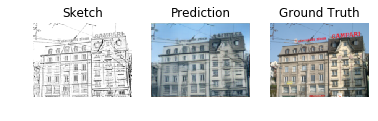

In [32]:
i = 3
x = X[i].reshape(m,n)
y = Y[i]
sub_plot(x, T[i], y)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [41]:
sketch = cv.imread('buildiing_10.jpg', 0)
sketch = imresize(sketch, sketch_dim)
sketch = sketch / 255.
sketch = sketch.reshape(1,m,n,1)

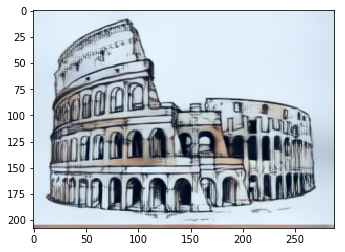

In [42]:
result, _ = model.predict(sketch)
imshow(result[0])

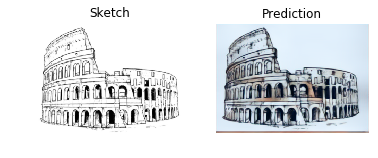

In [43]:
fig = plt.figure()
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(sketch[0].reshape(m,n), cmap='gray')
a.set_title('Sketch')
plt.axis("off")
a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(result[0])
a.set_title('Prediction')
plt.axis("off")
plt.show()

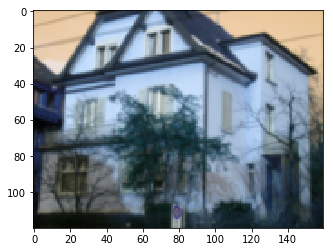

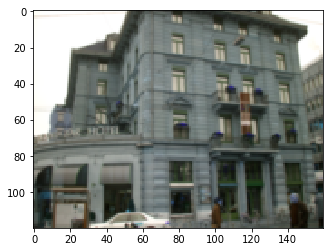

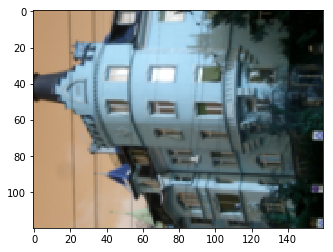

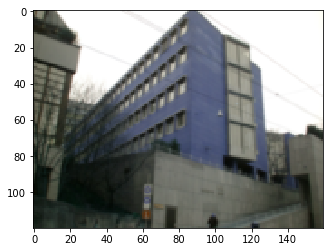

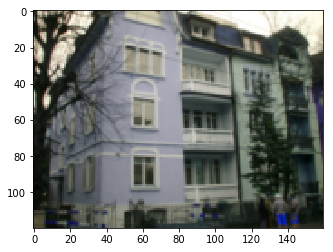

NameError: global name 'get_features' is not defined

In [11]:
_,_,_ = get_batch(0)